## Imports

In [1]:
# utils
import os
import sys
from pathlib import Path

PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

# basics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# metrics
from utils import config
from utils.plot.plot import GeneratePlots
from utils.reader import read_file_yaml
from utils.utils import get_last_modification_directory, set_params

np.random.seed(0)

## Reading datasets

In [2]:
path_outputs_url = PROJECT_DIR / "outputs"
path_data_url = PROJECT_DIR / "data"
file_path_parameters = PROJECT_DIR / "conf" / "parameters.yml"
parameters = read_file_yaml(file_path_parameters)
path_results_url = PROJECT_DIR / parameters["results"]["filepath"]

n_random = np.sort(
    [int(i.replace("random_n", "")) for i in os.listdir(path_results_url) if ".placehold" not in i]
)
path_random = ["random_n" + str(i) for i in n_random]
path_results = [path_results_url / i for i in path_random]

_, path_random = get_last_modification_directory(path_results, path_random, parameters)

ext_type = parameters["outputs"]["extension_type"]
ext_local_img = parameters["outputs"]["extension_local_img"]
ext_best_img = parameters["outputs"]["extension_best_img"]

In [3]:
path_data = {i: path_data_url / i for i in config.file_names}
path_params = {i: {j: path_results_url / i / j / "params" for j in config.file_names} for i in path_random}

In [4]:
data = {
    i_name: pd.read_csv(i_url / Path(i_name + f"{ext_type}"))
    if f"{i_name}_pca{ext_type}" not in os.listdir(i_url)
    else pd.read_csv(i_url / Path(i_name + "_pca" + ext_type))
    for i_name, i_url in path_data.items()
}

In [5]:
params = {}
for i_random, i_content in path_params.items():
    params[i_random] = {}
    for j_name, j_content in i_content.items():
        params[i_random][j_name] = {}
        for which in ["abilities", "diff_disc"]:
            try:
                params[i_random][j_name][which] = pd.read_csv(j_content / Path(which + ext_type), index_col=0)
            except Exception:
                continue

## Plot of difficulties

In [ ]:
figs = {}
for i_random, i_content in tqdm(list(params.items())):
    _plt_parameters = set_params(data, i_content)
    gp = GeneratePlots(data=data)
    fig, _ = gp.scatterplot_diff_disc(
        len(_plt_parameters.keys()), 2, plot_parameters=_plt_parameters, figsize=(20, len(config.file_names) + 12)
    )
    figs[i_random] = fig
    plt.close()

In [ ]:
i_figs_unique = {}
for i in tqdm(config.file_names):
    i_figs_unique[i] = {}
    for i_random, i_content in list(params.items()):
        _plt_parameters = set_params({i: data[i]}, i_content)
        gp = GeneratePlots(data={i: data[i]})
        fig, _ = gp.scatterplot_diff_disc_unique(
            1, 2, plot_parameters={i: _plt_parameters[i]}, figsize=(22, 7)
        )
        i_figs_unique[i][i_random] = fig
        plt.close()

In [9]:
# viz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


class GeneratePlots:
    def __init__(self, pij=None, data=None):
        self.pij = pij
        self.data = data

    def _scatterplot(self,
                    nrows=1,
                    ncols=1,
                    figsize=(18, 18),
                    plot_parameters=None,
                    fontsize=20,
                    xlabel="$pca_{(1)}$", 
                    ylabel="$pca_{(2)}$"):
        _fig = {}
        for which_param in plot_parameters:
            (name, _, params) = which_param
            fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
            points = axes.scatter(**params)
            # axes.set_title(name)
            axes.set_xlabel(xlabel, fontsize=fontsize)
            axes.set_ylabel(ylabel, fontsize=fontsize)
            fig.colorbar(points, ax=axes)
            fig.tight_layout()
            _fig[name] = fig
            plt.close()
        return _fig
        
    def scatterplot(self,
                    nrows=1,
                    ncols=1,
                    figsize=(18, 18),
                    plot_parameters=None,
                    fontsize=20,
                    xlabel="$pca_{(1)}$", 
                    ylabel="$pca_{(2)}$"):
        _fig = {}
        (name_diff, _, params_diff), (name_disc, _, params_disc)  = plot_parameters[0], plot_parameters[1] 
        params_diff["s"] = ((params_disc["c"] - params_disc["c"].min())/(params_disc["c"].max() - params_disc["c"].min())) * 100
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        points = axes.scatter(**params_diff)
        axes.set_xlabel(xlabel, fontsize=fontsize)
        axes.set_ylabel(ylabel, fontsize=fontsize)
        fig.colorbar(points, ax=axes)
        fig.tight_layout()
        _fig[name_diff] = fig
        plt.close()
        return _fig


In [13]:
params_general = {
    "nrows": 1,
    "ncols": 1,
    "figsize": (10,8),
    "fontsize": 26
}
i_figs_unique_param = {}
for i in tqdm(["varied", "breast_cancer", "aniso"]):#config.file_names):
    i_figs_unique_param[i] = {}
    for i_random, i_content in list(params.items()):
        _plt_parameters = set_params({i: data[i]}, i_content)
        gp = GeneratePlots(data={i: data[i]})
        params_general.update({"plot_parameters": _plt_parameters[i]})
        if i not in ["wine", "iris", "breast_cancer", "diabetes", "digits"]:
            params_general.update({"xlabel": r"$x_{1}$", "ylabel": r"$x_{2}$"})
        fig = gp.scatterplot(
            **params_general
        )
        i_figs_unique_param[i][i_random] = fig
        plt.close()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.55s/it]


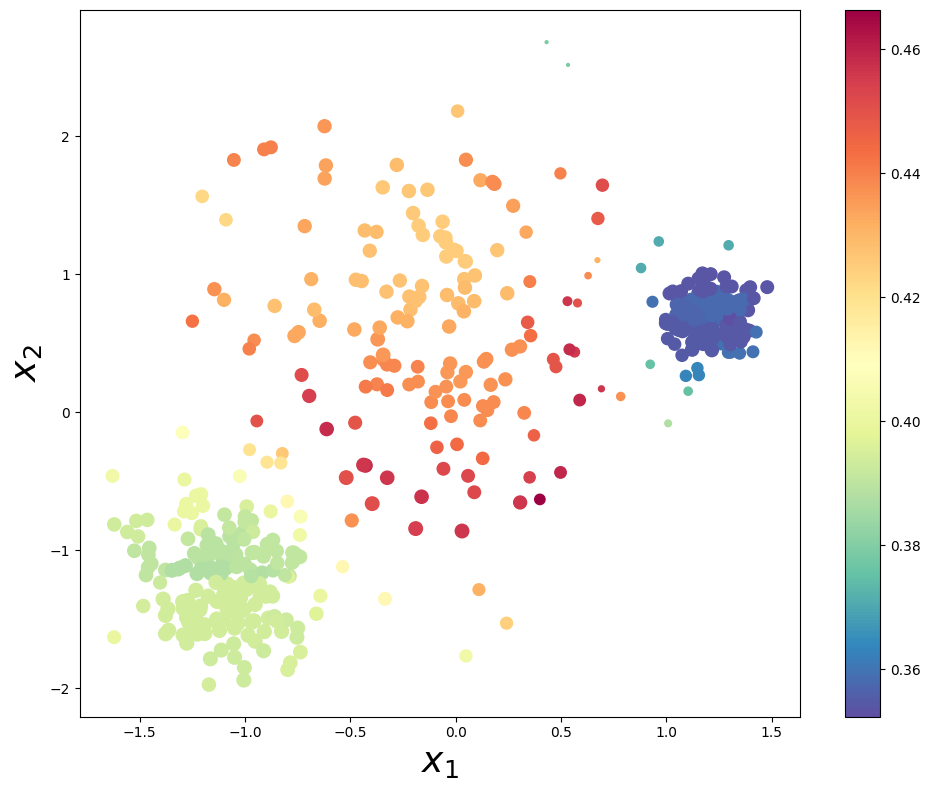

In [15]:
i_figs_unique_param["varied"]["random_n0"]["difficulties"]#["varied"]["random_n0"]["difficulties"]

## Save

In [ ]:
for i_random, i_content in tqdm(figs.items()):
    i_content.savefig(
        path_outputs_url / Path(i_random + "_" + "diff_disc_all" + ext_best_img), format=ext_best_img[1:]
    )  # eps format
    i_content.savefig(
        path_outputs_url / Path(i_random + "_" + "diff_disc_all" + ext_local_img), format=ext_local_img[1:],
        **parameters["outputs"]["args"]
    )  # png format

In [16]:
for i_name, i_content in tqdm(list(i_figs_unique_param.items())):
    for j_random, j_content in list(i_content.items())[:1]:
        for which_param, k_figure in j_content.items():
            k_figure.savefig(
                path_outputs_url / Path(i_name + "_" + j_random + "_" + which_param + ext_best_img),
                format=ext_best_img[1:]
            )  # eps format
            k_figure.savefig(
                path_outputs_url / Path(i_name + "_" + j_random + "_" + which_param + ext_local_img),
                format=ext_local_img[1:],
                **parameters["outputs"]["args"]
            )  # png format

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


In [ ]:
# 2, 